In [2]:
#My path
path = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Deep_learning/Final project/data/dataset/Revco/'

path_data = '/Users/claes/Documents/GitHub/DeepLearningProject/Data/'

#Your path
#path = '/Users/claes/Desktop/Deep_learning/Week_6'

In [8]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load the data
df = pd.read_parquet(path + 'combined_cleaned_data.parquet')

data_normalized = df.to_numpy()

# Create a custom Dataset class
class FreezerDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        x = self.data[index]
        return x, x  # For autoencoders, input and target are the same

# Create the dataset and dataloaders
freezer_dataset = FreezerDataset(data_normalized)
batch_size = 2048
train_loader = DataLoader(freezer_dataset, batch_size=batch_size, shuffle=True)

In [9]:
import torch.nn as nn

# Define the number of features (i.e., columns in your dataset)
num_features = data_normalized.shape[1]

class AutoEncoder(nn.Module):
    def __init__(self, hidden_units, latent_features=2):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=num_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=latent_features)
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=num_features)
        )

    def forward(self, x): 
        z = self.encoder(x)
        x_hat = torch.sigmoid(self.decoder(z))
        return {'z': z, 'x_hat': x_hat}

# Initialize the autoencoder model
hidden_units = 64
latent_features = 2
net = AutoEncoder(hidden_units, latent_features)
cuda = torch.cuda.is_available()

if cuda:
    net = net.cuda()

print(net)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=11, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=11, bias=True)
  )
)


In [10]:
import torch
cuda = torch.cuda.is_available()
print(f"Model is on GPU: {next(net.parameters()).is_cuda}")

Model is on GPU: True


In [11]:
import torch
import torch.optim as optim
import torch.nn as nn

# Initialize the optimizer and loss function
optimizer = optim.Adam(net.parameters(), lr=0.0005)
loss_function = nn.MSELoss()

num_epochs = 10
train_loss = []

# Move the model to the GPU if available
if cuda:
    net = net.cuda()

for epoch in range(num_epochs):
    batch_loss = []
    net.train()
    
    for x, _ in train_loader:
        # Move input data to GPU if available
        if cuda:
            x = x.cuda()
        
        # Forward pass
        outputs = net(x)
        x_hat = outputs['x_hat']
        
        # Compute the loss
        loss = loss_function(x_hat, x)
        
        # Backward pass and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Store the batch loss
        batch_loss.append(loss.item())
    
    train_loss.append(np.mean(batch_loss))
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss[-1]:.4f}")

Epoch 1/10, Loss: 0.0043
Epoch 2/10, Loss: 0.0027
Epoch 3/10, Loss: 0.0024
Epoch 4/10, Loss: 0.0022
Epoch 5/10, Loss: 0.0021
Epoch 6/10, Loss: 0.0021
Epoch 7/10, Loss: 0.0020
Epoch 8/10, Loss: 0.0020
Epoch 9/10, Loss: 0.0020
Epoch 10/10, Loss: 0.0019


### Gem model

In [8]:
# Save only the model's state dictionary
model_save_path = 'autoencoder_weights.pth'
torch.save(net.state_dict(), model_save_path)
print(f"Model weights saved to {model_save_path}")

Model weights saved to autoencoder_weights.pth


### Hent model

In [12]:
# Create a new instance of your model
net_loaded = AutoEncoder(hidden_units=64, latent_features=2)

# Move the model to GPU if available
if cuda:
    net_loaded = net_loaded.cuda()

# Load the saved weights into the model
model_save_path = 'autoencoder_weights.pth'
net_loaded.load_state_dict(torch.load(model_save_path))
print(f"Model weights loaded from {model_save_path}")

# Set the model to evaluation mode if you are using it for inference
net_loaded.eval()

Model weights loaded from autoencoder_weights.pth


C:\Users\claes\AppData\Local\Temp\ipykernel_21384\1773006121.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net_loaded.load_state_dict(torch.load(model_save_path))


AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=11, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=11, bias=True)
  )
)

In [13]:
import matplotlib.pyplot as plt

def detect_anomalies(data, model, threshold=0.05):
    model.eval()
    data_tensor = torch.tensor(data, dtype=torch.float32)
    
    if cuda:
        data_tensor = data_tensor.cuda()
    
    with torch.no_grad():
        outputs = model(data_tensor)
        x_hat = outputs['x_hat']
        reconstruction_error = torch.mean((data_tensor - x_hat) ** 2, dim=1).cpu().numpy()
    
    anomalies = reconstruction_error > threshold
    return anomalies, reconstruction_error

## Afprøve på træningsdata

In [14]:
anomalies, reconstruction_errors = detect_anomalies(data_normalized, net)

# Plot the reconstruction error distribution
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_errors, bins=50, alpha=0.75)
plt.axvline(x=0.05, color='r', linestyle='--')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.show()

# Print out the indices of anomalies
anomaly_indices = np.where(anomalies)[0]
print(f"Detected {len(anomaly_indices):,} anomalies out of {len(data_normalized):,} samples.")

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.64 GiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Of the allocated memory 5.60 GiB is allocated by PyTorch, and 4.50 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## Afprøve på valid sæt

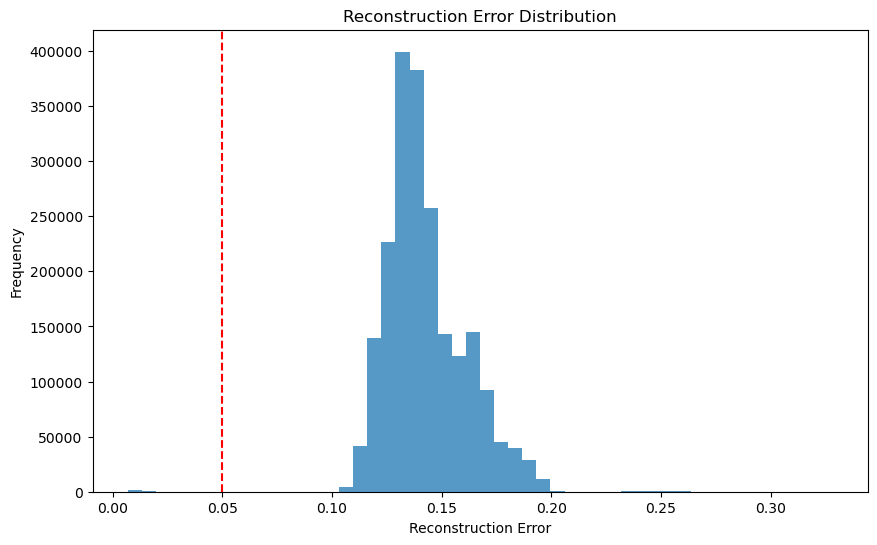

Detected 2,082,832 anomalies out of 2,085,256 samples.
Accuracy percentage: 99.88%


In [17]:
# Step 1: Load the data
df = pd.read_parquet(path + 'around_events_data_806018.parquet')
#df = pd.read_parquet('around_events_data_806018.parquet')

# Step 2: Preprocess the data
#df.drop(columns=['Datetime', 'State', 'Type', 'Event'], inplace=True)
df.drop(columns=['Datetime', 'State', 'Type', 'Event', 'main_fault'], inplace=True)

# Step 3: Normalize the data
scaler = MinMaxScaler()
valid_data_normalized = scaler.fit_transform(df)

# Example: Detect anomalies on the training data
anomalies, reconstruction_errors = detect_anomalies(valid_data_normalized, net)

# Plot the reconstruction error distribution
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_errors, bins=50, alpha=0.75)
plt.axvline(x=0.05, color='r', linestyle='--')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.show()

# Print out the indices of anomalies
anomaly_indices = np.where(anomalies)[0]
percentage_accuracy = (len(anomaly_indices) / len(valid_data_normalized)) * 100
print(f"Detected {len(anomaly_indices):,} anomalies out of {len(valid_data_normalized):,} samples.")
print(f"Accuracy percentage: {percentage_accuracy:.2f}%")